## Objective

* To predict the salary of a job based on the data posted on the company's website or on any job portal
* To compare how addition of text(job description) into the models increases the prediction power

## About data

Job salary prediction dataset from Kaggle has been used to perform the analysis.
Following is the link for the data description [Data Description](https://www.kaggle.com/c/job-salary-prediction/data)

## Approach

Running a classfier on the data is never the first step of any analysis be it on numerical data or text data. We will have to first understand the data, clean it, perform exploratory data analysis following which we will perform feature extraction and only then think of training a classifier on the training data.

So as a logical first step, i started with importing the data and performing exploratory data analysis on the data. For easy understanding of the entire analysis, i have listed all the steps that i have followed below and divide my entire analysis based in the same chronological order.

1. Exploratory Data analysis for the entire data
2. Exploratory Data analysis - Job descriptions
3. Models with just categorical variables
4. Models with text variables
5. Conclusion

### 1.Exploratory data analysis - for the entire data

In [1]:
# Import all required modules for the analysis(make sure that you installed all these modules prior to importing)
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import math
from IPython.display import display,HTML
from patsy import dmatrices
import seaborn as sns; sns.set()

import warnings
warnings.filterwarnings('ignore')
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Reading the train data
train_df = pd.read_csv('Train_rev1.csv')

In [3]:
# Checking the data types in the train data
print (train_df.info())

# Let's look at the unique values present in the data frame to have a general understanding of the data
names = train_df.columns.values
uniq_vals = {}
for name in names:
    uniq_vals[name] = train_df.loc[:,name].unique()
    print("Count of %s : %d" %(name,uniq_vals[name].shape[0]))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
Id                    244768 non-null int64
Title                 244767 non-null object
FullDescription       244768 non-null object
LocationRaw           244768 non-null object
LocationNormalized    244768 non-null object
ContractType          65442 non-null object
ContractTime          180863 non-null object
Company               212338 non-null object
Category              244768 non-null object
SalaryRaw             244768 non-null object
SalaryNormalized      244768 non-null int64
SourceName            244767 non-null object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB
None
Count of Id : 244768
Count of Title : 135436
Count of FullDescription : 242138
Count of LocationRaw : 20986
Count of LocationNormalized : 2732
Count of ContractType : 3
Count of ContractTime : 3
Count of Company : 20813
Count of Category : 29
Count of SalaryRaw : 97286
Count of SalaryNormalized

**As the dataset is huge with 250 k rows, we will first run various models on a very sample of 2500 rows and then use those models on the larger dataset**

In [52]:
import random
random.seed(1)
indices = list(train_df.index.values)
random_5000 = random.sample(indices,5000)

# Subsetting the train data based on the random indices
train_df1 = train_df.loc[random_5000].reset_index()

Now let's see the log transformation of the normalized salaries in this data and compare them with the actual normalized salaries. Taking log transformation will remove the skewness from the output variable and would give better results while predicting the outputs

Text(0.5,1,'Histogram of log of Salaries normalized')

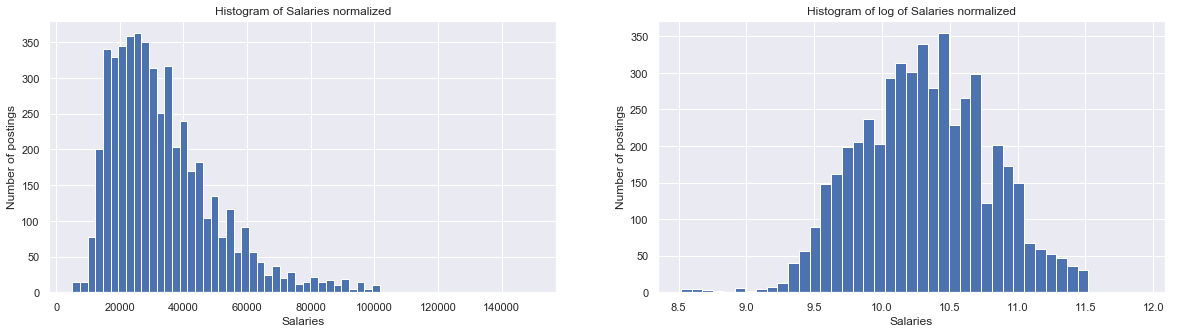

In [53]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize = (20,5))

ax1.hist(train_df1['SalaryNormalized'], bins='auto')
ax1.set_xlabel('Salaries')
ax1.set_ylabel('Number of postings')
ax1.set_title('Histogram of Salaries normalized')

ax2.hist(log(train_df1['SalaryNormalized']), bins='auto')
ax2.set_xlabel('Salaries')
ax2.set_ylabel('Number of postings')
ax2.set_title('Histogram of log of Salaries normalized')

## 2. Exploratory Data analysis - Job descriptions

Let's look into the job descriptions and try to answer some of the questions to have more clarity
1. What are the top 5 parts of speech in the job descriptions? How frequently do they appear?
2. How do these numbers change if you exclude stopwords?
3. What are the 10 most common words after removing stopwords and lemmatization?

**1. What are the top 5 parts of speech in the job descriptions? How frequently do they appear?** 

In [54]:
import re
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize, sent_tokenize 
stop_words = set(stopwords.words('english')) 
from string import punctuation
import collections

While looking at the data, you can observe that the numbers are masked as *** and they turn out to be of no value for us in the analysis. In addition to that, there are a few data cleaning steps that i have performed in the below code
1. Remove website links from the data
2. Remove punctuations
3. Removing numbers

By running these steps, we can achieve a higher accuracy as the data becomes more cleaned and the predictive power of the algorithm increases because of that.

In [55]:
# To obtain the full width of a cell in a dataframe
pd.set_option('display.max_colwidth', -1)
desc = train_df1.loc[1,'FullDescription']

# Creating a list of words from all the job descriptions in train_df1 data
all_desc = []
for i in range(0,train_df1.shape[0]):
    desc = train_df1.loc[i,'FullDescription']
    desc1 = desc.lower()
    # Removing numbers, *** and www links from the data using regex
    desc2 = re.sub('[0-9]+\S+|\s\d+\s|\w+[0-9]+|\w+[\*]+.*|\s[\*]+\s|www\.[^\s]+','',desc1)
    # Removing punctuation
    for p in punctuation:
        desc2 = desc2.replace(p,'')
    all_desc.append(desc2)


Now next step after cleaning the descriptions is to tokenize them. Here for simplicity purpose, i have just considered word tokenize. We can also tokenize the descriptions by sentences but that is not suitable for our problem here.
[Refer this link](https://textminingonline.com/dive-into-nltk-part-ii-sentence-tokenize-and-word-tokenize) to know more about word tokenizer and sentence tokenizer

In [56]:
# Creating word tokens for all the descriptions
final_list = []
for desc in all_desc:
    word_list = word_tokenize(desc)
    final_list.extend(word_list)

In [57]:
final_list[:5]

['genting', 'casinos', 'uk', 'is', 'looking']

Now before finding the most common parts of speech in the job description, we first need to tag each word with the relevant parts of speech. I have used *pos_tag* from *nltk library* to tag the parts of speech. This uses the pos tags from *treebank pos repository.*   
After creating the pos tags, the next would be to find the frequent occurence of each parts of speech and find the most common parts of speech

In [58]:
# 3. Tagging parts of speech
pos_tagged = nltk.pos_tag(final_list)

# 4. Identifying the most common parts of speech
tag_fd = nltk.FreqDist(tag for (word, tag) in pos_tagged)
tag_fd.most_common()[:5]

[('NN', 279355), ('JJ', 126947), ('IN', 115931), ('NNS', 91583), ('DT', 91467)]

You can see that Noun(NN) , adjective(JJ), preposition(IN), determiner(DT), plural nouns(NNS)  are the most common parts of speech from the job descriptions.
[Refer this link](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) to look at the descriptions of the parts of speech for the above result

**2.How do these numbers change if you exclude stopwords?**  
In english,for that matter in any language, there will be a lot of stop words that repeat a lot of times in the sentence but do not actually carry a lot of information.  
For examples: the, a , an ,and etc.  
nltk library has a repository for stop words. Let's remove those stopwords and check how the above results will change.

In [59]:
# Excluding stopwords from the analysis
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

list_wo_stopwords = []
for w in final_list:
    if w not in stop_words:
        list_wo_stopwords.append(w)
        
# 3. Tagging parts of speech
pos_tagged_wo_sw = nltk.pos_tag(list_wo_stopwords)

# 4. Identifying the most common parts of speech
tag_fd_wo_sw = nltk.FreqDist(tag for (word, tag) in pos_tagged_wo_sw)
tag_fd_wo_sw.most_common()[:5]

[('NN', 271026),
 ('JJ', 130937),
 ('NNS', 90164),
 ('VBG', 45919),
 ('VBP', 30942)]

After removing stopwords, there are two important observations in comparison to the previous result
1. Prepositions and determiners disappeared from the top 5 set as most of these are present in the stopwords imported from NLTK 
2. The counts of nouns and plural nouns have decreased and the adjectives have increased.
3. Verb, gerund or present participle(VBG) and Verb, non-3rd person singular present(VBP) moved to the top 5 list

**3. What are the 10 most common words after removing stopwords and lemmatization?**

Here is some backgrond information about [lemmatization](https://textminingonline.com/dive-into-nltk-part-iv-stemming-and-lemmatization)

As we have already removed stopwords and created a dataframe list_wo_stopwords earlier, our first step here would be to perform lemmatization and then identify the 10 most common words.  
I have also plotted the wordcloud of all the words to visualize these words.  

,words,freq
31,experience,7702
34,role,5857
10,team,5542
299,client,5409
39,work,5234
43,business,5101
323,skill,4388
63,service,4299
235,sale,4152
156,working,3949


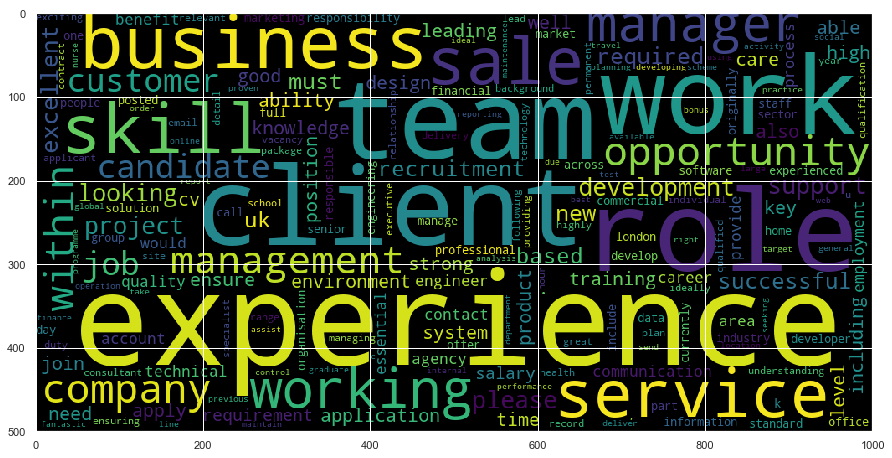

In [60]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatization without specifying parts of speech
list_lemmatized = []
for word in list_wo_stopwords:
    list_lemmatized.append(lemmatizer.lemmatize(word))

word_freq_lem = dict(collections.Counter(list_lemmatized))
keys = list(word_freq_lem.keys())
values = list(word_freq_lem.values())
df_lem = pd.DataFrame({'words':keys,'freq':values})
display(df_lem.sort_values(by = 'freq',ascending = False)[:10])

from wordcloud import WordCloud
from collections import Counter
word_could_dict=Counter(word_freq_lem)
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)


## 3. Model without text variables

As i have told, we will perform the analysis with 2 types of variables
1. Non-text variables
2. Text variables

Just to revisit, our objective is to predict the salaries based on the information posted on the website including variables such as location, company and job description.

With this in mind, let's proceed with the analysis

For this analysis, let's define the target variable based on the salary normalized. This converts the problem into a classfication problem and reduces the complexity. Further, based on the requirement we can perform a regression analysis to predict a number for the salary

**Creating the target column by splitting the salary normalized into high(above 50th percentile) and low(below 50th percentile)**

In [61]:
p_50 = np.percentile(train_df1['SalaryNormalized'], 50)
train_df1['target'] = train_df1['SalaryNormalized'].apply(lambda x: 1 if x>=p_50 else 0)

### Creation of features
**Creating a proxy variable for location**  
Here as there are so many locations, creating dummy variable will bloat the dataset a lot. So, we will create a proxy variable
for the location by taking the cities with high cost of living under one group(1) and the others in a separate group(0).

We have considered 17 cities as cities with high cost of living [Source](https://www.thisismoney.co.uk/money/mortgageshome/article-5283699/The-cheapest-expensive-cities-live-in.html)

In [62]:
costly_cities = ['London','Brighton','Edinburgh','Bristol','Southampton','Portsmouth','Exeter','Cardiff','Manchester',
                 'Birmingham','Leeds','Aberdeen','Glasgow','Newcastle','Sheffield','Liverpool']
costly_cities_lower = [x.lower() for x in costly_cities]

train_df1['location_flag'] = train_df1['LocationNormalized'].apply(lambda x: 1 if x in costly_cities else 0)
train_df1.head(2)

,index,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,target,location_flag
0,35222,68234454,Bar & Leisure Supervisor,"Genting Casinos UK is looking for an experienced and enthusiastic Bar Leisure Supervisor to join the team at our newlyrefurbished venue in Leicester. Trading between 11am and 6am 7 days per week, the club encompasses a modern bar, bar food offering and busy gaming floor. Reporting to the General Manager, the Bar Leisure Supervisor must have gained experience within a similar role, and be able to adopt a flexible attitude to work in order to meet the requirements of the business. The main responsibilities and duties are as follows: Supporting the management team in the management of the hospitality operation, both front and back of house, and with stock control To lead by example in delivering exceptional standards of customer service To demonstrate the ability to motivate staff, identify training needs and effectively deploy staff within the Hospitality area to maximise performance To work alongside the management team and Marketing Advocate in coordinating marketing and promotional offers, and to lead staff through their implementation To ensure the Hospitality department remains of a high standard in relation to equipment, presentation, service and overall ambience In return we offer a competitive salary and flexible benefits package including pension, health cash plan and access to numerous discounted goods and services. Genting Casinos UK is part of the Genting Group, a leading resort development specialist in the leisure and gaming industry, with 39 years of global experience in developing, operating and marketing internationally acclaimed casinos and integrated resorts in different parts of the world. In the UK, Genting is the largest casino operator with more than **** casinos nationwide. We offer visitors a complete night out with restaurant, bars, entertainment and gaming. Regrettably, due to a high volume of applications, only successful candidates will be contacted. This job was originally posted as www.caterer.com/JobSeeking/BarLeisureSupervisor_job****",Leicester Leicestershire East Midlands,Leicester,NaN,NaN,Genting UK,Hospitality & Catering Jobs,"Up to 17,000 per annum",17000,caterer.com,0,0
1,149213,70762305,Principal Development Engineer,"Principal Development Engineer RF Microwave / Space Products Profile for job **** SE 2Di AB Based: Scotland, or you must be willing to relocate to this area ATA Recruitment is working in conjunction with a leading RF s, liaising with purchasing to source relevant parts. **** Your role will also require you to be directly involved at initial design stage of Microwave SubSystems (**** of your time), signing off final designs and drawings, building prototypes including all testing and documentation. **** Continuously ensuring the development meets the specification outlined at bid stage. **** Liaising with internal engineering and manufacturing teams on Space Qualifications and managing Space Manufacturing Sequences. 10. A key aspect of your role will be to work with the Engineering Director and Technical Managers to secure funding for projects from UK and European agencies, bodies and commercial partnerships. **** Implement the best methods and practices to manage cost and risk in product development and product manufacturing for Space requirements. **** Set the standards and implement required processes and procedures within the organisation for all activities providing service to the space product line. Experience and background: 1. Degree in Physics, RF Microwave, Electrical / Electronics, Nuclear Physics or a Science related area. 2. Senior engineer within the RF, Microwave or Space sector, and or an Electronics Engineer with Space sector engineering experience. 3. Must experienced in Microwave CAD (HFSS, CST, uwizard, WASPNET, ADS or similar package). Salary: **** ****

**Creating dummy variables for all the columns except for job descriptions and splitting the data into train and validation set**  

In [63]:
# Dropping job description column from the dataset
train_x = train_df1.drop(['FullDescription','index','Id','LocationRaw','Title','Company','LocationNormalized','SalaryRaw','SalaryNormalized',
                    'target'],axis=1)

train_x1 = pd.get_dummies(train_x,drop_first=True)
X_n = np.array(train_x1)
y_n = np.array(train_df1['target'])

from sklearn.model_selection import train_test_split
X_train_num, X_val_num, y_train_num, y_val_num = train_test_split(X_n, y_n, test_size=0.3, random_state=1)


**Let's run a Bernoulli Naive Bayes algorithm to predict the salary of a job using all variables except job description. I have selected this algorithm because most often Naive bayes gives good results in simplistic scenarios.  
It also acts as a good starting point to compare the effect of non-text and text variables on prediction.**

In [64]:
# Bernoulli
from sklearn.naive_bayes import BernoulliNB
clf = BernoulliNB()
clf.fit(X_train_num, y_train_num)

from sklearn import metrics
prediction_train = clf.predict(X_val_num)
mat_n = metrics.confusion_matrix(y_val_num, prediction_train)
mat_n
print (metrics.accuracy_score(y_val_num, prediction_train))

0.6553333333333333


**Using test data to predict the salary**

In [65]:
# Baseline accuracy
1-(sum(y_val_num)/len(y_val_num))


0.496

We can observe that the model performed a bit better(0.676) than the baseline accuracy(0.492) but not to a satisfactory level. So lets move on to the next part of the analysis to see what effect does job descriptions have on accuracy.

## 4. Models using job descriptions as variables

Now let's run the Naive Bayes using the words in the job description as variables. You will notice that text in itself has a higher prediction power than the non-text variables

Here i have followed a bag-of-words model for creating the features for the model

For this model, we will run both Bernoulli and Multinomial Naive Bayes([click to know more](https://syncedreview.com/2017/07/17/applying-multinomial-naive-bayes-to-nlp-problems-a-practical-explanation/)), to check the performance of both the models

We will run both the models in multiple steps
1. Without removing stopwords from the data
2. After removing stopwords from the data
3. After lemmatizing the data

This will help us understand the effect of each step on the accuracy of the result

Here i have created a function to make it easy to perform the above 3 steps

### Naive Bayes models( Bernoulli and Multinomial)

In [66]:
def naive_bayes_models(l):
    # Counting the occurence of each word in the corpus
    from sklearn.feature_extraction.text import CountVectorizer
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(l)
    count_vect.get_feature_names()
    X_matrix= X_train_counts.todense()

    y = np.array(train_df1['target'])

    # Creating the train and test split
    from sklearn.model_selection import train_test_split
    X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(X_train_counts, y, test_size=0.3, random_state=1)

    #Multinomial

    from sklearn.naive_bayes import MultinomialNB
    clf_m = MultinomialNB().fit(X_train_m, y_train_m)
    labels_m = clf_m.predict(X_val_m)

    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score
    mat_m = confusion_matrix(y_val_m, labels_m)

    # Bernoulli
    # Changing the data to binary to input BernoulliNB
    x_train_b1 = X_train_counts.todense()
    X_train_counts_ber = np.where(x_train_b1 >=1 ,1,0)

    # Creating the train and test split for bernoulli
    from sklearn.model_selection import train_test_split
    X_train_b, X_val_b, y_train_b, y_val_b = train_test_split(X_train_counts_ber, y, test_size=0.3, random_state=1)

    from sklearn.naive_bayes import BernoulliNB
    clf_b = BernoulliNB().fit(X_train_b, y_train_b)
    labels_b = clf_b.predict(X_val_b)

    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score
    mat_b = confusion_matrix(y_val_b, labels_b)
    print ('Confusion matrix:',mat_b)
    print ('Accuracy using BernoulliNB:',round(accuracy_score(y_val_b, labels_b),3))
    

    print ('Confusion matrix:',mat_m)
    print ('Accuracy using MultinomialNB:',round(accuracy_score(y_val_m, labels_m),3))
    test_mse = metrics.mean_squared_error(clf_m.predict(X_val_m), y_val_m)
    print('test_mse :', round(test_mse,3))

**1. Without removing stopwords**

In [67]:
naive_bayes_models(all_desc)

Confusion matrix: [[588 156]
 [239 517]]
Accuracy using BernoulliNB: 0.737
Confusion matrix: [[574 170]
 [192 564]]
Accuracy using MultinomialNB: 0.759
test_mse : 0.241


You can see that job descriptions by themselves have given a higher accuracy(75.8%) than all the other variables combined(67.6%).Now lets move to the next step and see if removing stopwords add any value to our analysis in accuractely predicting the salaries

**2. After removing stopwords from the data**

In [68]:
# Removing stopwords
def remove_stopwords(s):
    big_regex = re.compile(r'\b%s\b' % r'\b|\b'.join(map(re.escape, stop_words)))
    return big_regex.sub('',s)

all_desc_wo_sw = [remove_stopwords(s) for s in all_desc]
naive_bayes_models(all_desc_wo_sw)

Confusion matrix: [[594 150]
 [237 519]]
Accuracy using BernoulliNB: 0.742
Confusion matrix: [[569 175]
 [195 561]]
Accuracy using MultinomialNB: 0.753
test_mse : 0.247


Removing stopwords did not have much effect on accuracy. In fact, there is a decrease in accuracy. So lets try our final pre-processing step of lemmatization to see for any further effect

**3. After lemmatizing the data**

Lemmatization usually refers to doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.([Click to know more](https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html))

We will lemmatize and see if there is any improvement in the result

In [69]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

from nltk.corpus import wordnet

def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None 

# Lemmatizing the data
all_desc_lemm = []
for i in range(0,len(all_desc_wo_sw)):
    desc = all_desc_wo_sw[i]
    desc2 = re.sub('[0-9]+\S+|\s\d+\s|\w+[0-9]+|\w+[\*]+.*|\s[\*]+\s|www\.[^\s]+','',desc)
    for p in punctuation:
        desc2 = desc2.replace(p,'')
    tagged = nltk.pos_tag(word_tokenize(desc2))
    list_lemmatized = []
    for word, tag in tagged:
        wntag = get_wordnet_pos(tag)
        if wntag is None:# not supply tag in case of None
            list_lemmatized.append(lemmatizer.lemmatize(word)) 
        else:
            list_lemmatized.append(lemmatizer.lemmatize(word, pos=wntag))
    k = ' '.join(list_lemmatized)   
    all_desc_lemm.append(k)

naive_bayes_models(all_desc_lemm)

Confusion matrix: [[583 161]
 [240 516]]
Accuracy using BernoulliNB: 0.733
Confusion matrix: [[573 171]
 [195 561]]
Accuracy using MultinomialNB: 0.756
test_mse : 0.244


After lemmatization, we can see a marginal improvement in accuracy(76.3%) in comparison to our step where we have run Naive Bayes multinomial model without removing stopwords or lemmatization(75.9%).

### Random forest

In [70]:
def random_forest(l):
    # Counting the occurence of each word in the corpus
    from sklearn.feature_extraction.text import CountVectorizer
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(l)
    count_vect.get_feature_names()
    X_matrix= X_train_counts.todense()

    y = np.array(train_df1['target'])

    # Creating the train and test split
    from sklearn.model_selection import train_test_split
    X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(X_train_counts, y, test_size=0.3, random_state=1)
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import accuracy_score
    model = RandomForestClassifier(n_estimators = 250,max_features = None).fit(X_train_m, y_train_m)
#     grid_params = {'criterion': ['gini'], 'max_features' : [None], 'n_estimators': [300]}
#     para_search = GridSearchCV(model, grid_params, scoring = 'accuracy', cv = 5).fit(X_train_m, y_train_m)
#     best_model = para_search.best_estimator_
    labels_r = model.predict(X_val_m)
    
    train_mse = metrics.mean_squared_error(model.predict(X_train_m), y_train_m)
    test_mse = metrics.mean_squared_error(labels_r, y_val_m)
    print(train_mse)
    print(test_mse)
    print ('Accuracy using Random Forest:',round(accuracy_score(y_val_m, labels_r),3))
    mat_r = confusion_matrix(y_val_m, labels_r)
    print(mat_r)
    return model

best_model1 = random_forest(all_desc)


0.0017142857142857142
0.24733333333333332
Accuracy using Random Forest: 0.753
[[540 204]
 [167 589]]


In [71]:
best_model1 = random_forest(all_desc_lemm)

0.0017142857142857142
0.25733333333333336
Accuracy using Random Forest: 0.743
[[544 200]
 [186 570]]


In [61]:
all_desc_lemm

['genting casino uk look experienced enthusiastic bar leisure supervisor join team newlyrefurbished venue leicester trading day per week club encompass modern bar bar food offering busy game floor report general manager bar leisure supervisor must gain experience within similar role able adopt flexible attitude work order meet requirement business main responsibility duty follow support management team management hospitality operation front back house stock control lead example deliver exceptional standard customer service demonstrate ability motivate staff identify training need effectively deploy staff within hospitality area maximise performance work alongside management team marketing advocate coordinate market promotional offer lead staff implementation ensure hospitality department remain high standard relation equipment presentation service overall ambience return offer competitive salary flexible benefit package include pension health cash plan access numerous discount good ser

### XGBoost

In [84]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

xgb_params = {
    'n_estimators': 600, 
    'max_depth': 3,
    'subsample': 0.9,
    'colsample_bytree': 0.9,
    'objective':'binary:logistic',
    'learning_rate': 0.1    
}


# from sklearn.feature_extraction.text import CountVectorizer
# count_vect = CountVectorizer()
# X_train_counts = count_vect.fit_transform(all_desc)
# count_vect.get_feature_names()
# X_matrix= X_train_counts.todense()

# y = np.array(train_df1['target'])

# # Creating the train and test split
# from sklearn.model_selection import train_test_split
# X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(X_train_counts, y, test_size=0.3, random_state=1)
# model = xgb.XGBClassifier()
# param_dist = {"max_depth": [3,5,10],
#               "min_child_weight" : [1,3,6],
#               "n_estimators": [400,600,800],
#               "learning_rate": [0.05, 0.1],}
# grid_search = GridSearchCV(model, param_grid=param_dist, cv = 3, 
#                                    verbose=10, n_jobs=-1)
# grid_search.fit(X_train_m, y_train_m)

# grid_search.best_estimator_

def xg_boost(l):
    
    # Counting the occurence of each word in the corpus
    from sklearn.feature_extraction.text import CountVectorizer
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(l)
    count_vect.get_feature_names()
    X_matrix= X_train_counts.todense()

    y = np.array(train_df1['target'])

    # Creating the train and test split
    from sklearn.model_selection import train_test_split
    X_train_m, X_val_m, y_train_m, y_val_m = train_test_split(X_train_counts, y, test_size=0.3, random_state=1)

    model = XGBClassifier(**xgb_params).fit(X_train_m, y_train_m)
    
    labels_r = model.predict(X_val_m)
    
    train_mse = metrics.mean_squared_error(model.predict(X_train_m), y_train_m)
    test_mse = metrics.mean_squared_error(labels_r, y_val_m)
    print(train_mse)
    print(test_mse)
    print ('Accuracy using XGBoost:',round(accuracy_score(y_val_m, labels_r),3))
    mat_r = confusion_matrix(y_val_m, labels_r)
    print(mat_r)
    return model

best_model1 = xg_boost(all_desc)

0.032285714285714286
0.21866666666666668
Accuracy using XGBoost: 0.781
[[570 174]
 [154 602]]


In [77]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=800,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

## 5. Conclusion


The bag-of-words model used is the simplest possible feature space. Other natural language processing
techniques could help, such as removing stop words and using longer strings of words as
features such as bigrams and trigrams. Another appealing option would be to use simple syntatic
analysis to extract noun phrases such as “heavy machinery technician” from the description.

You can see that there is a gradual increase in accuracy starting with 65.5% using just categorical variables to 78.1% using  job descriptions with XGBoost. This result can further be improved if we can involve deep learning models to train on the job descriptions and use them to predict the salaries.

## Thanks for reading!